# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

In [4]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head() 

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


Let's drop the columns we won't use

In [5]:
churn=churn.drop(['CUST_ID','RECON_SMS_NEXT_MTH','RECON_TELE_NEXT_MTH','RECON_EMAIL_NEXT_MTH'],axis=1)

In [6]:
churn['CHURN_IND'].unique()

array([1, 0])

Let's find the null values and if they're in big amounts replace them with the mean.

In [7]:
churn.isna().sum()

ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [8]:
mean_age=churn['AGE'].mean()
churn['AGE']=churn['AGE'].fillna(mean_age)

Let's drop the last two null values.

In [9]:
churn=churn.dropna()

Let's detect the outliers and replace them

0
46204


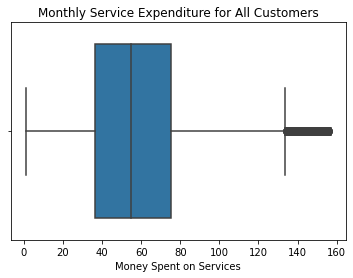

In [13]:
plot=sns.boxplot(x=churn['MONTHLY_SPEND'])
plt.title("Monthly Service Expenditure for All Customers")
plt.xlabel("Money Spent on Services")
#let's calculate the whiskers
median = np.median(churn['MONTHLY_SPEND'])
upper_quartile = np.percentile(churn['MONTHLY_SPEND'], 75)
lower_quartile = np.percentile(churn['MONTHLY_SPEND'], 25)
iqr = upper_quartile - lower_quartile
upper_whisker = churn['MONTHLY_SPEND'][churn['MONTHLY_SPEND']<=upper_quartile+1.5*iqr].max()
lower_whisker = churn['MONTHLY_SPEND'][churn['MONTHLY_SPEND']>=lower_quartile-1.5*iqr].min()
upper_whisker
# let's print out how many outliers there are so when we remove them we can check the new number of rows to confirm it
print( len(churn[churn['MONTHLY_SPEND'] > 156.75]))
print( len(churn[churn['MONTHLY_SPEND'] < 156.75]))

Now let's replace them with the average mothly spend.

In [14]:
mean_monthlyspend=churn['MONTHLY_SPEND'].mean()
churn['MONTHLY_SPEND']= np.where(churn['MONTHLY_SPEND'] > 156.75, mean_monthlyspend,churn['MONTHLY_SPEND'])
churn['MONTHLY_SPEND'].value_counts()

54.540000    4179
75.188082    3666
72.720000    2764
27.270000    2216
31.810000    1678
             ... 
19.790000       1
91.540000       1
49.410000       1
31.780000       1
62.280000       1
Name: MONTHLY_SPEND, Length: 6519, dtype: int64

Let's do the same for age

121
46084


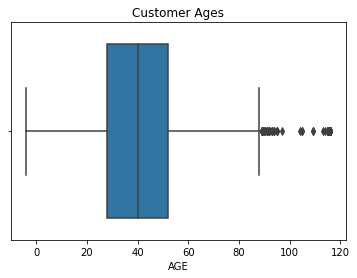

In [16]:
plot=sns.boxplot(x=churn['AGE'])
plt.title("Customer Ages")
#let's calculate the whiskers
median = np.median(churn['AGE'])
upper_quartile = np.percentile(churn['AGE'], 75)
lower_quartile = np.percentile(churn['AGE'], 25)
iqr = upper_quartile - lower_quartile
upper_whisker = churn['AGE'][churn['AGE']<=upper_quartile+1.5*iqr].max()
lower_whisker = churn['AGE'][churn['AGE']>=lower_quartile-1.5*iqr].min()
# let's print out how many outliers there are so when we remove them we can check the new number of rows to confirm it
print( len(churn[churn['AGE'] >= 88]))
print( len(churn[churn['AGE'] < 88]))

In [17]:
mean_age=churn['AGE'].mean()
churn['AGE']= np.where(churn['AGE'] >= 88, mean_age,churn['AGE'])
churn['AGE']= np.where(churn['AGE'] < 10, mean_age,churn['AGE'])


And a shorter version for plan access fee since the boxplot is more informative this time so we won't need to calculate the cutoff point.

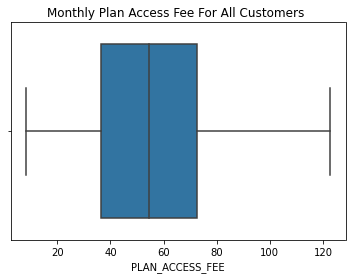

In [19]:
#churn['PLAN_ACCESS_FEE'].value_counts()
plot=sns.boxplot(x=churn['PLAN_ACCESS_FEE'])
plt.title("Monthly Plan Access Fee For All Customers ")
mean_age=churn['PLAN_ACCESS_FEE'].mean()
churn['PLAN_ACCESS_FEE']= np.where(churn['PLAN_ACCESS_FEE'] >= 150, mean_age,churn['PLAN_ACCESS_FEE'])

Let's turn categorical values into numerical values

In [20]:
churn['BYO_PLAN_STATUS']=churn['BYO_PLAN_STATUS'].astype('category')
churn['Is_NONBYO']=churn['BYO_PLAN_STATUS'].cat.codes
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,Is_NONBYO
INDEX,,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,1
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,1
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,0
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,1
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,1


In [21]:
churn['CFU']=churn['CFU'].astype('category')
churn['Is_SMALLBUSINESS']=churn['CFU'].cat.codes
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,Is_NONBYO,Is_SMALLBUSINESS
INDEX,,,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,1,0
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,1,0
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,0,0
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,1,0
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,1,0


In [22]:
churn['CONTRACT_STATUS']=churn['CONTRACT_STATUS'].astype('category')
churn['Is_OFFCONTRACT']=churn['CONTRACT_STATUS'].cat.codes
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,Is_NONBYO,Is_SMALLBUSINESS,Is_OFFCONTRACT
INDEX,,,,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,1,0,1
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,1,0,1
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,0,0,1
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,1,0,1
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,1,0,1


In [23]:
churn['COUNTRY_METRO_REGION']=churn['COUNTRY_METRO_REGION'].astype('category')
churn['Is_METROREGION']=churn['COUNTRY_METRO_REGION'].cat.codes
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,...,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,Is_NONBYO,Is_SMALLBUSINESS,Is_OFFCONTRACT,Is_METROREGION
INDEX,,,,,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,...,24,SAMSUNG,1,61.40,COUNTRY,WA,1,0,1,0
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,...,24,APPLE,1,54.54,METRO,NSW,1,0,1,1
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,...,12,APPLE,1,2.50,COUNTRY,WA,0,0,1,0
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,...,24,APPLE,1,6.48,COUNTRY,VIC,1,0,1,0
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,...,24,APPLE,1,100.22,METRO,NSW,1,0,1,1


In [24]:
churn['STATE']=churn['STATE'].astype('category')
churn["STATE_cat"] = churn["STATE"].cat.codes
churn.head()
print('0:ACT, 1:NSW, 2:NT, 3:QLD, 4:SA, 5:TAS, 6:VIC, 7:WA')

0:ACT, 1:NSW, 2:NT, 3:QLD, 4:SA, 5:TAS, 6:VIC, 7:WA


In [25]:
churn['HANDSET_USED_BRAND']=churn['HANDSET_USED_BRAND'].astype('category')
churn["HANDSET_BRAND_CATEGORY"] = churn["HANDSET_USED_BRAND"].cat.codes
churn.head()
print('0:APPLE, 1:GOOGLE, 2:HUAWEI, 3:OTHER, 4:SAMSUNG, 5:UNKNOWN')


0:APPLE, 1:GOOGLE, 2:HUAWEI, 3:OTHER, 4:SAMSUNG, 5:UNKNOWN


In [26]:
churn=churn.drop(['CONTRACT_STATUS','CFU','BYO_PLAN_STATUS','COUNTRY_METRO_REGION','STATE','HANDSET_USED_BRAND'],axis=1)
churn

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,Is_NONBYO,Is_SMALLBUSINESS,Is_OFFCONTRACT,Is_METROREGION,STATE_cat,HANDSET_BRAND_CATEGORY
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,46,54.54,15,0,24,24,1,61.40,1,0,1,0,7,4
2,60,3,55.0,59,54.54,5,0,24,24,1,54.54,1,0,1,1,1,0
3,65,1,29.0,65,40.90,15,0,12,12,1,2.50,0,0,1,0,7,0
4,31,1,51.0,31,31.81,31,0,24,24,1,6.48,1,0,1,0,6,0
5,95,1,31.0,95,54.54,0,0,24,24,1,100.22,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46202,10,1,61.0,9,27.27,7,0,0,0,0,27.27,0,0,0,0,6,3
46203,2,1,53.0,2,54.54,2,0,24,24,1,54.99,1,0,1,1,1,5
46204,47,1,22.0,47,72.72,7,17,24,24,0,72.72,1,0,2,0,1,0


Let's see if we'll find any interactions between CHURN_IND and any of the variables.

Text(0.5, 1.0, 'Pairplot of Churn_IND and The Other Variables')

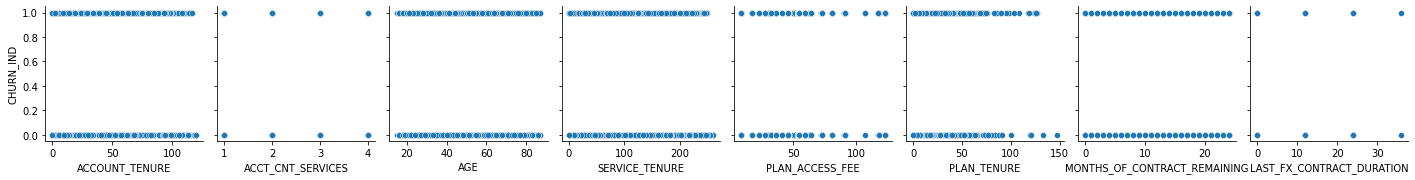

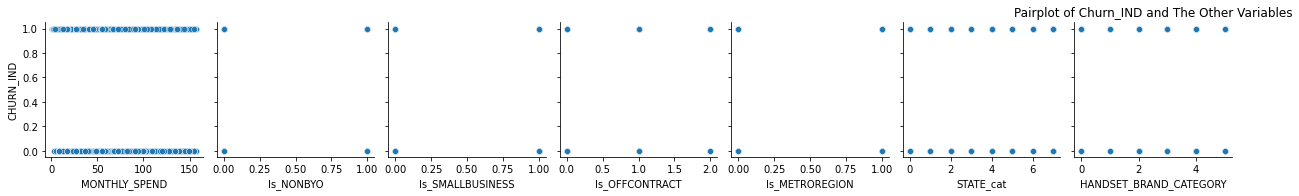

In [28]:
sns.pairplot(
       churn,
    x_vars=["ACCOUNT_TENURE", "ACCT_CNT_SERVICES", "AGE",'SERVICE_TENURE','PLAN_ACCESS_FEE','PLAN_TENURE','MONTHS_OF_CONTRACT_REMAINING','LAST_FX_CONTRACT_DURATION'],
    y_vars=["CHURN_IND"],
)
sns.pairplot(
       churn,
    x_vars=['MONTHLY_SPEND','Is_NONBYO','Is_SMALLBUSINESS','Is_OFFCONTRACT','Is_METROREGION','STATE_cat','HANDSET_BRAND_CATEGORY'],
    y_vars=["CHURN_IND"],
)
plt.title("Pairplot of Churn_IND and The Other Variables")

**Some analysis**
We can't see any clear interactions between any categories and CHURN_IND

Let's get more help with the RFE function.

In [29]:
feature_cols = np.array(['Is_NONBYO','Is_SMALLBUSINESS','Is_OFFCONTRACT','Is_METROREGION'])
X = churn[feature_cols]
y = churn['CHURN_IND']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
lr=LogisticRegression()
rfe=RFE(estimator=lr, n_features_to_select=2, step=1)
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=2)

In [31]:
# Do predictions on test set
train_preds=rfe.predict(X_train)
test_preds=rfe.predict(X_test)
print('Train accuracy')
print(accuracy_score(y_train, train_preds))
print('Test accuracy')
print(accuracy_score(y_test,test_preds))

Train accuracy
0.6573693323233416
Test accuracy
0.6498214478952494


In [32]:
X_train.columns[rfe.support_]

Index(['Is_NONBYO', 'Is_OFFCONTRACT'], dtype='object')

In [33]:
rfe.ranking_


array([1, 3, 1, 2])

I've repeated the process a few times and found the most important variables for CHURN_IND.

Let's Build a Logistic Regression Model

In [34]:
churn_for_log=churn.drop(["ACCOUNT_TENURE", "ACCT_CNT_SERVICES", "AGE",'SERVICE_TENURE','PLAN_ACCESS_FEE','PLAN_TENURE','MONTHS_OF_CONTRACT_REMAINING','LAST_FX_CONTRACT_DURATION','MONTHLY_SPEND','STATE_cat','HANDSET_BRAND_CATEGORY','PREV_CONTRACT_DURATION','Is_METROREGION','Is_SMALLBUSINESS'], axis=1)
churn_for_log


,CHURN_IND,Is_NONBYO,Is_OFFCONTRACT
INDEX,,,
1,1,1,1
2,1,1,1
3,1,0,1
4,1,1,1
5,1,1,1
...,...,...,...
46202,0,0,0
46203,1,1,1
46204,0,1,2


In [35]:
train, test= train_test_split(churn_for_log, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)
test

(36964, 3)
(9241, 3)


,CHURN_IND,Is_NONBYO,Is_OFFCONTRACT
INDEX,,,
13030,0,1,2
13791,0,0,1
31805,0,1,2
17595,1,1,2
5413,1,1,2
...,...,...,...
41128,1,0,1
37063,0,1,2
699,1,1,1


In [36]:
X_train=train.drop(['CHURN_IND'], axis=1)
y_train=train['CHURN_IND']
X_test= test.drop(['CHURN_IND'], axis=1)
y_test=test['CHURN_IND']
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36964, 2)
(36964,)
(9241, 2)
(9241,)


In [37]:
lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [38]:
# Do predictions on test set
train_preds=lr.predict(X_train)
test_preds=lr.predict(X_test)
print('Train accuracy')
print(accuracy_score(y_train, train_preds))
print('Test accuracy')
print(accuracy_score(y_test,test_preds))

Train accuracy
0.6552591710853803
Test accuracy
0.6582620928470945


In [39]:
print(lr.predict_proba(X_train)[:10])

[[0.6230294  0.3769706 ]
 [0.42606793 0.57393207]
 [0.68124447 0.31875553]
 [0.68124447 0.31875553]
 [0.68124447 0.31875553]
 [0.48979092 0.51020908]
 [0.68124447 0.31875553]
 [0.68124447 0.31875553]
 [0.68124447 0.31875553]
 [0.68124447 0.31875553]]


**Model Evaluation Time**
We have created the Logistic regression model. We can see that the model predicts better than chance but the accuracy is not very high. Let's evaluate the model.

In [40]:
churn['CHURN_IND'].value_counts()

0    28415
1    17790
Name: CHURN_IND, dtype: int64

In [41]:
print('Train Confusion Matrix:')
print(confusion_matrix(y_train,train_preds))

Train Confusion Matrix:
[[18455  4259]
 [ 8484  5766]]


In [42]:
print('Test Confusion Matrix:')
print(confusion_matrix(y_test,test_preds))

Test Confusion Matrix:
[[4623 1078]
 [2080 1460]]


**SOME ANALYSIS**
There were in total 46205 customer cases where in 17790 churn happened and in 28415 of the customer's stayed with the company. <br>
We can see in the training matrix that 4259 of the cases were wrongly predicted to be churn while they were no-churn cases. <br > 8484 of the churn cases were wrongly predicted to be no-churn. We can see the same pattern with the test matrix. <br>
Lets check the precision of our model with the following formula $\frac{TP}{TP + FP}$ <br>
18455/(18455+4259)=0.81249449678 <br>
We can see that of all the cases we hae predicted to be churn 80% is actually churn which is a good percentage. <br>
Recall:$\frac{TP}{TP + FN}$  <br>
18455/(18455+8484)=0.68506626081 <br>
We can see that from all the churn cases we've predicted 69% correcly which is better than chance but could be better. <br>
Accuracy: <br>
(18455+5766)/(18455+5766+4259+8484)=0.65525917108 <br>
We can see that we get the same percentage (66) as the predictions we made on our logistic regression model.
